This does what the original fig 2 was designed to do, but with proper particles.

We have a range of input values 0-1000 (something like line lengths in AU)
and 50 particles, each of which has a variance of 500
- that's our prior.
Start with particles at random locations.

The new observation is a single value also with a variance of 500.
For all particles multiply the prior with the observation.
To get the posterior sum over all particles and normalise.

Resample beta particles i.e. replace some of the particles (in this case 15) with new particles
generated from the posterior by randomly sampling weighted by the value of the posterior.

That's our new prior.

The first cell just shows straight decay and has:

observations = [100, 200, 300, 400, 500] 
plot_steps = [5] 

which is just 5 presentations, and plots the prior after the fifth

The second cell does 3 Hebbs followed by a single filler:
observations = [100, 200, 300, 100, 200, 300, 100, 200, 300, 500] # 3 reps of 100, 200, 300
plot_steps = [10]  # Plot only after these observation indices (1-based)


It runs things 1000 times to get smoother plots. 




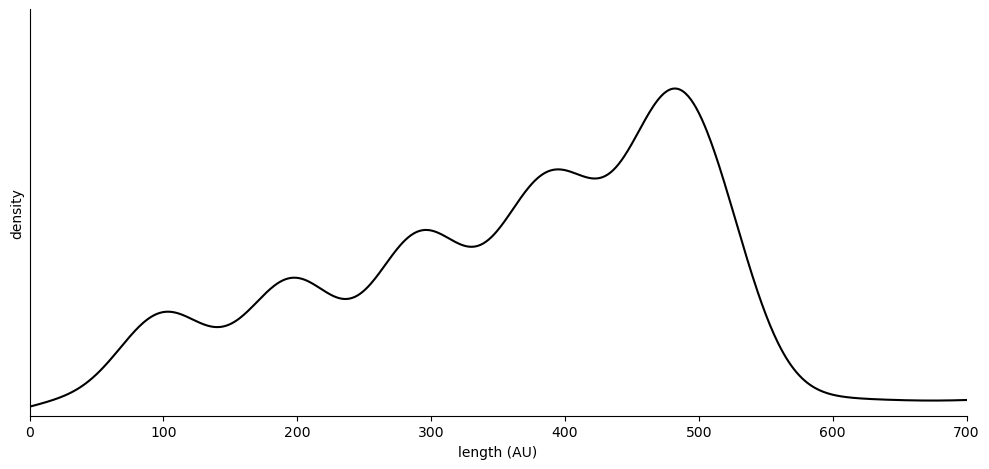

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
particle_variance = 500.0 
observation_variance = 500.0 

num_particles = 50 # was 100 works with 25
num_resample = 15   # was 30 works with 5
line_length_points = np.arange(1001) # range of 'line_lengths'
num_runs = 1000 # iterations. Use 1000 for stable results

'''
should check plot_steps.max() <= len(observations)
'''
observations = [100, 200, 300, 400, 500] # value of successive stims
plot_steps = np.array([5])  # Plot only after these observation indices (1-based)
# now we're only plotting at the end

y_max = 0.004 # hardwired to cope with both plots
              # sets both the range of the plot and y_ticks
x_limit_for_plots = 700

# plot dimensions in inches
x_size = 10
y_size = 5


def gaussian(x, mean, variance):
    return norm.pdf(x, mean, np.sqrt(variance))

def compute_prior(particles, variance, line_length_points):
    prior = np.zeros_like(line_length_points, dtype=float)
    std = np.sqrt(variance)
    for center in particles:
        local_min = int(max(0, np.ceil(center - 4 * std)))
        local_max = int(min(1000, np.floor(center + 4 * std)))
        x_vals = np.arange(local_min, local_max + 1)
        g_vals = gaussian(x_vals, center, variance)
        prior[x_vals] += g_vals
    return prior / np.sum(prior)

def apply_observation(particles, obs_value, line_length_points, particle_variance, observation_variance):
    prior = compute_prior(particles, particle_variance, line_length_points)
    likelihood = gaussian(line_length_points, mean=obs_value, variance=observation_variance)
    likelihood /= np.sum(likelihood)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)

    resampled = np.random.choice(line_length_points, size=num_resample, replace=True, p=posterior)
    replace_indices = np.random.choice(len(particles), size=num_resample, replace=False)
    new_particles = particles.copy()
    new_particles[replace_indices] = resampled

    return new_particles


# Run the simulation and average priors
avg_priors = [np.zeros_like(line_length_points, dtype=float) for _ in observations]
for _ in range(num_runs):
    particles = np.random.choice(line_length_points, size=num_particles, replace=False)
    for i, obs in enumerate(observations):
        particles = apply_observation(particles, obs, line_length_points, particle_variance, observation_variance)
        prior = compute_prior(particles, particle_variance, line_length_points)
        avg_priors[i] += prior

avg_priors = [p / num_runs for p in avg_priors]

# Select priors to plot
selected_indices = [i for i in range(len(observations)) if (i + 1) in plot_steps]
n_plots = len(selected_indices)

# Compute a shared y-axis limit
# y_max = max(np.max(avg_priors[i]) for i in selected_indices)

# Create subplots. Only doing one plot now
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2.5 * n_plots), sharex=True)
fig.set_size_inches(x_size, y_size)
if n_plots == 1:
    axes = [axes]

for ax, i in zip(axes, selected_indices):
    step = i + 1
    ax.plot(line_length_points, avg_priors[i], color='black')
    ax.set_ylim(0, y_max * 1.05)  # add small margin
    ax.set_ylabel('density')
    ax.grid(False)


start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, 900, 100))
#ax.yaxis.set_ticks([0, y_max])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticklabels([]) # don't bother with y-ticks
ax.yaxis.set_ticks([])
    
axes[-1].set_xlabel('length (AU)')
ax.grid(False)
plt.xlim(0,x_limit_for_plots)
# axes[-1].set_xlabel('line_length_points (0 to 1000)')
axes[-1].set_xlabel('length (AU)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Figure4_Hebb_particles_figA.png', dpi = 500, bbox_inches='tight')
plt.show()


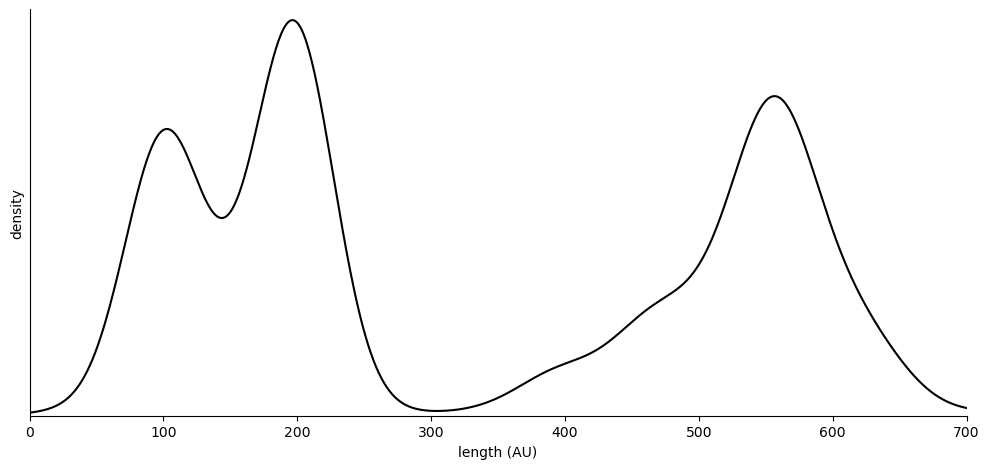

In [ ]:


# Now do the Hebb plot. Must run the cell above first

observations = [100, 200, 400, 100, 200, 500, 100, 200, 600] # 3 reps of 100, 200, 300
plot_steps = [9]  # Plot only after these observation indices (1-based)



# Run the simulation and average priors
avg_priors = [np.zeros_like(line_length_points, dtype=float) for _ in observations]
for _ in range(num_runs):
    particles = np.random.choice(line_length_points, size=num_particles, replace=False)
    for i, obs in enumerate(observations):
        particles = apply_observation(particles, obs, line_length_points, particle_variance, observation_variance)
        prior = compute_prior(particles, particle_variance, line_length_points)
        avg_priors[i] += prior

avg_priors = [p / num_runs for p in avg_priors]

# Select priors to plot
selected_indices = [i for i in range(len(observations)) if (i + 1) in plot_steps]
n_plots = len(selected_indices)

# Compute a shared y-axis limit
# y_max = max(np.max(avg_priors[i]) for i in selected_indices) # roughly 0.004

# Create subplots
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2.5 * n_plots), sharex=True)
fig.set_size_inches(x_size, y_size)
if n_plots == 1:
    axes = [axes]

for ax, i in zip(axes, selected_indices):
    step = i + 1
    #ax.plot(line_length_points, avg_priors[i], label=f'After Obs {step} (mean={observations[i]})', color='tab:blue')
    ax.plot(line_length_points, avg_priors[i], color='black')
    ax.set_ylim(0, y_max * 1.05)  # add small margin
    ax.set_ylabel('density')
    ax.grid(False)

start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(0, 900, 100))
# ax.yaxis.set_ticks([0, y_max])
ax.yaxis.set_ticklabels([]) # don't bother with y-ticks
ax.yaxis.set_ticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim(0,x_limit_for_plots)

axes[-1].set_xlabel('length (AU)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Figure4_Hebb_particles_figB.png', dpi = 500, bbox_inches='tight')
plt.show()
